In [1]:
from lib import create_dataframe

te = create_dataframe('task_events', 1, False)
tu = create_dataframe('task_usage', 1, False)

22/01/09 21:43:23 WARN Utils: Your hostname, pasokon resolves to a loopback address: 127.0.1.1; using 192.168.1.96 instead (on interface wlo1)
22/01/09 21:43:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/09 21:43:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/09 21:43:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Will download at most 1 file(s) from task_events.
Polling bucket gs://clusterdata-2011-2/task_events
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_events] (1/500).
Will download at most 1 file(s) from task_usage.
Polling bucket gs://clusterdata-2011-2/task_usage
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_usage] (1/500).


In [2]:
from pyspark.sql import functions as F

In [3]:
max_cpu = tu.select(tu.job_id, F.round(tu.maximum_cpu_rate.cast('double')*100 ,2).alias('mcrate'))\
    .groupBy('job_id').mean('mcrate')
max_cpu = max_cpu.select(max_cpu.job_id, F.round('avg(mcrate)',2).alias('mcrate'))

In [4]:
filtered_te = te.filter(te.event_type == '2').select(te.job_id).distinct()

In [32]:
max_cpu_evt = filtered_te.join(max_cpu, on='job_id')

In [1]:
from lib import Table, init
sc = init()
tu = Table('task_usage', sc, 1, False)
te = Table('task_events', sc, 1, False)

22/01/09 21:45:13 WARN Utils: Your hostname, pasokon resolves to a loopback address: 127.0.1.1; using 192.168.1.96 instead (on interface wlo1)
22/01/09 21:45:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/09 21:45:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/09 21:45:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
max_cpu_task = tu.select(['job_id', 'maximum_cpu_rate'])\
                        .mapValues(lambda x: round(float(x)*100))\
                        .reduceByKey(max)

filtered_te = te.select(['job_id', 'event_type'])\
    .filter(lambda x: x[1] == '2').distinct()

In [3]:
    # Join both RDD to have the maximum CPU rate for each evicted job
max_cpu_evt = filtered_te.join(max_cpu_task)

In [18]:
finale = max_cpu_evt.map(lambda x: (x[1][1], 1))

<AxesSubplot:ylabel='Count'>

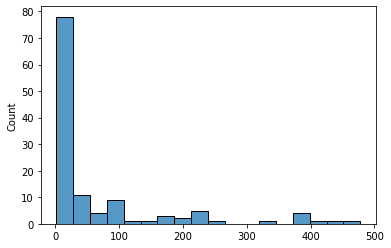

In [16]:
import seaborn as sns

data = finale.collect()

sns.histplot(data)